In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
tickers = ["AAPL", "MSFT", "GOOGL"]

df = yf.download(
    tickers=tickers,
    period="5y",
    interval="1d",
    group_by="ticker",
    progress=False
)

In [3]:
# Flatten columns: (ticker, field) -> "ticker_field"
if hasattr(df.columns, "levels"):  # MultiIndex check
    df.columns = [f"{t}_{f}" for t, f in df.columns]
else:
    # If only one ticker, yfinance may return single-level columns like "Open"
    # Prefix them with that ticker (optional)
    only = tickers[0] if len(tickers) == 1 else "UNKNOWN"
    df.columns = [f"{only}_{c}" for c in df.columns]

In [4]:
# assumes columns like: AAPL_Open, AAPL_Close, MSFT_Close, ...
close_cols = [c for c in df.columns if c.endswith("_Close")]

# compute returns
rets = df[close_cols].pct_change()

# rename return columns: AAPL_Close -> AAPL_Ret
rets.columns = [c.replace("_Close", "_Ret") for c in close_cols]

# append to df
df = pd.concat([df, rets], axis=1)

# drop first row (no previous close)
df = df.iloc[1:].copy()

In [5]:
tol = 0.0005  # absolute tolerance in return units (0.05%)

df["AAPL_target"] = (df["AAPL_Ret"] > (df["AAPL_Ret"].shift(1) + tol)).astype(int)

# drop first row since yesterday return is NaN for the first valid day
df = df.dropna(subset=["AAPL_Ret"]).copy()
df = df.iloc[1:].copy()  # because shift(1) creates NaN on first ro

<Axes: xlabel='Date'>

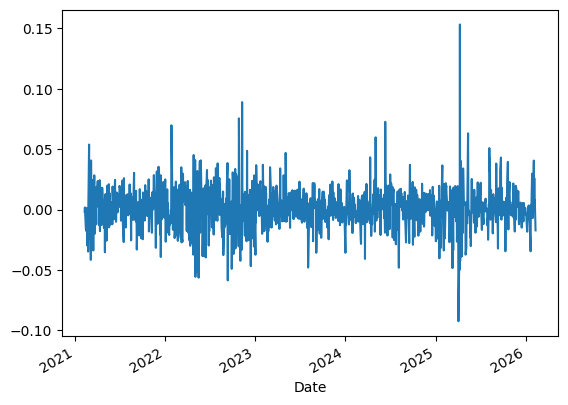

In [6]:
df['AAPL_Ret'].plot()

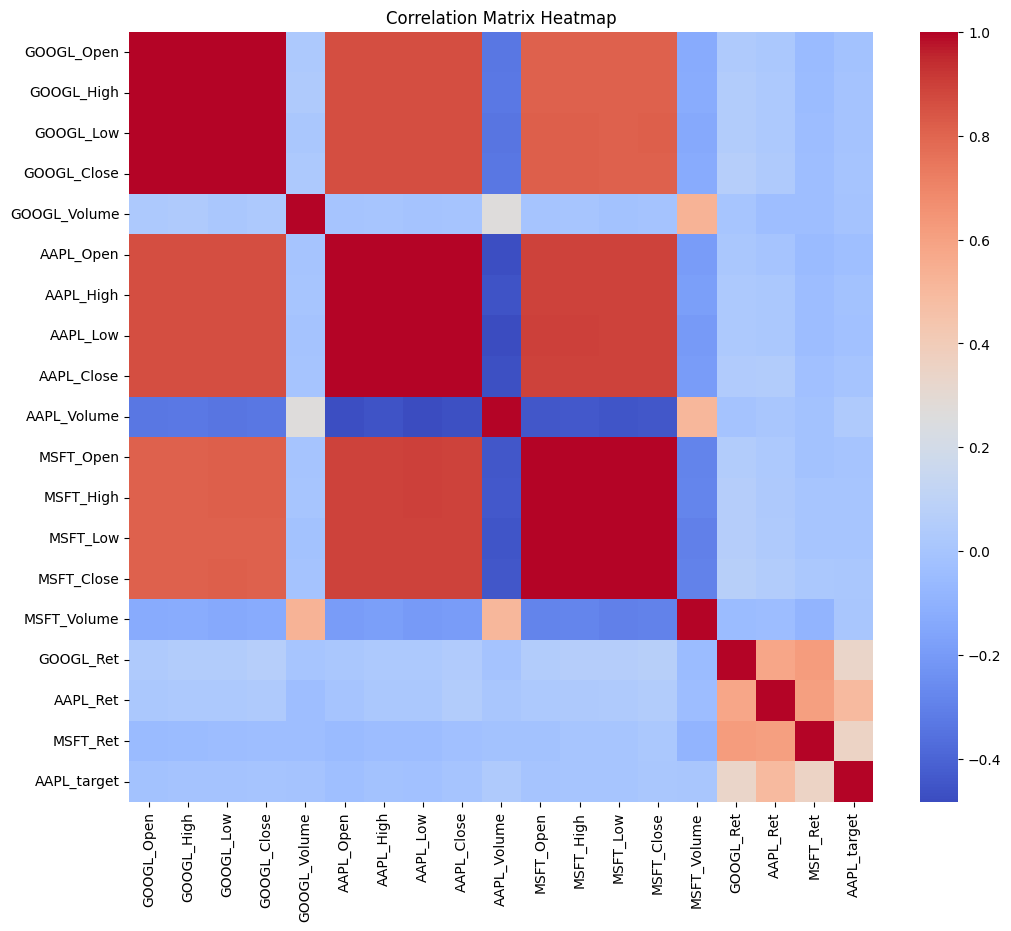

In [7]:
# Plot the correlation matrix
plt.figure(figsize=(12, 10))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False)
plt.title('Correlation Matrix Heatmap')
plt.show()

In [8]:
# Features
X = (df.drop(columns=rets)).drop(columns=["AAPL_target"]).copy()

# Target
y = df[["AAPL_target"]].copy()